In [846]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import csv

In [847]:
c = 3.0e8  # (m/s)
density = 1850  # kg/m³ (SiO2)
kB = 1.380649e-23 # J/K
epsilon_0 = 8.854187817e-12 # (C^2)*(N^-1)*(m^-2)
n_md = 1  # medium refractive index
n_p = 1.46 # particle refractive index
R = 75e-9  # particle radius (m)
T = 297 # K
lamb = 780*1e-9  # (m)
NA = 0.77
P = 0.5 # Total Power (W)
m_gas = 4.81e-26 # molecular mass of air
Pressure_atm = 1013.25 #mbar (1 atm)
Pressure = (Pressure_atm/1013.25)
eta_air = 18.27e-6 # Pa # (J.T.R.Watson (1995)).
d_gas = 0.372e-9 #m #(Sone (2007)), ρSiO2

In [848]:
k = 2*np.pi/lamb
w_0 = lamb/(np.pi*NA) # incident beam waist (m)
m_rri = n_p/n_md #relative refractive index
z_R = (np.pi * w_0**2) / lamb #rayleigh range
volume = (4/3) * np.pi * (R**3)
m = density * volume  # kg

In [849]:

def Gamma_chang(radius, Pressure_mbar): #essa pressão foi uma função retirada do repositório https://github.com/AshleySetter/optoanalysis/blob/master/Damping_radius_relation.ipynb
    Press = 100*Pressure_mbar
    ave_velocity = (8*kB*T/(np.pi*m_gas))**(1/2)
    Gamma0 = 8*Press/(np.pi*ave_velocity*radius*density)/2
    return 2*Gamma0  #Isso tem unidade de Hz.

def Gamma_env(Pressure_mbar):
    def mfp(P_gas):
        mfp_val = kB*T/(2**0.5*np.pi*d_gas**2*P_gas)
        return mfp_val
    
    Pressure_pascals = 100*Pressure_mbar
    s = mfp(Pressure_pascals)
    K_n = s/R
    c_K = 0.31*K_n/(0.785 + 1.152*K_n + K_n**2)
    gamma = 6*np.pi*eta_air*R/m * 0.619/(0.619 + K_n) * (1+c_K)
    return gamma #Isso está em Hz

def R_curv(z):
    z_safe = np.where(z == 0, 1e-40, z)       #Isso aqui impede que o código quebre em z = 0 substituindo esse
    return z_safe*(1+((z_R**2)/(z_safe**2)))  #ponto por um outro valor muito pequeno diferente de zero.

def gouy_phase(z):
    return np.arctan(z/z_R)

def w(z):
    return w_0*((1+((z**2)/(z_R**2)))**(1/2))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

In [850]:
dt = 1e-8 #s
N = 100000
t = np.linspace(0, N*dt, N)
gamma_hz = Gamma_env(Pressure) #Hz
#gamma_hz = Gamma_chang(R,Pressure)
D = kB*T/(gamma_hz*m)

x = np.linspace(-w_0, w_0, len(t))
y = np.linspace(-w_0, w_0, len(t))
z = np.linspace(-4*z_R, 4*z_R, len(t))

In [851]:
def E_counter(x,y,z):
    E1 = (np.sqrt((P/2)/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*z+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))
    E2 = (np.sqrt((P/2)/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(1j*(k*z+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))
    return E1+E2

def E_single(x,y,z):
    return (np.sqrt(P/(np.pi*w_0**2)))*(w_0/w(z))*np.exp((-((x**2)+(y**2)))/(w(z)**2))*np.exp(-1j*(k*z+k*(((x**2)+(y**2))/(2*R_curv(z))) - gouy_phase(z)))

def I(E):
    return c*epsilon_0*(abs(E)**2)/2

I_x, I_y = I(E_counter(x, 0, 0)), I(E_counter(0, y, 0))
I_z_counter = I(E_counter(0, 0, z))
I_z_single = I(E_single(0,0,z))

F_grad_x = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_x, x)
F_grad_y = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_y, y)

F_scatt_z = ((128*(np.pi**5)*(n_md**5)*(R**6))/(3*c*(lamb**4)))*((((m_rri**2)-1)/((m_rri**2) + 2))**2)*I_z_single
F_grad_z_single = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_z_single, z)
F_grad_z_counter = (2*np.pi*n_md*(R**3)/c)*(((m_rri**2)-1)/((m_rri**2)+2))*np.gradient(I_z_counter, z)

@njit(fastmath=True)
def dx_dt(v):
    return v

@njit(fastmath=True)
def dv_dt(pos, v, F, gamma_hz, m):
    return (F/m) - gamma_hz*v

In [852]:
@njit(fastmath=True)
def runge_kutta(t, v_init, pos_init, dt):
    positions = np.zeros((len(t), 2))
    velocities = np.zeros((len(t), 2))
    
    positions[0] = pos_init
    velocities[0] = v_init 

    for i in range(len(t) - 1):
        F_grad_x_curr = np.interp(positions[i, 0], x, F_grad_x)
        
        forces_z1 = np.interp(positions[i, 1], z, (F_grad_z_single + F_scatt_z))
        forces_z2 = np.interp(positions[i, 1], z, F_grad_z_counter)
        
        if (i < len(t)*0.35) or (i > len(t)*0.65):    
            F_grad_z_curr = forces_z2
        else:
            F_grad_z_curr = forces_z1
        
        #F_grad_z_curr = forces_z1
        
        # Atualizações para cada dimensão (x, y, z)
        for dim, F_grad in enumerate([F_grad_x_curr, F_grad_z_curr]):
            
            k1_pos = velocities[i, dim] * dt
            k1_v = dv_dt(positions[i, dim], velocities[i, dim], F_grad, gamma_hz, m) * dt
            
            k2_pos = (velocities[i, dim] + 0.5 * k1_v) * dt
            k2_v = dv_dt(positions[i, dim] + 0.5 * k1_pos, velocities[i, dim] + 0.5 * k1_v, F_grad, gamma_hz, m) * dt
            
            k3_pos = (velocities[i, dim] + 0.5 * k2_v) * dt
            k3_v = dv_dt(positions[i, dim] + 0.5 * k2_pos, velocities[i, dim] + 0.5 * k2_v, F_grad, gamma_hz, m) * dt
            
            k4_pos = (velocities[i, dim] + k3_v) * dt
            k4_v = dv_dt(positions[i, dim] + k3_pos, velocities[i, dim] + k3_v, F_grad, gamma_hz, m) * dt
            
            positions[i + 1, dim] = positions[i, dim] + (1 / 6) * (k1_pos + 2 * k2_pos + 2 * k3_pos + k4_pos)
            velocities[i + 1, dim] = velocities[i, dim] + (1 / 6) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
            
            thermal_noise = np.sqrt(2 * kB * T * gamma_hz * m) * np.random.normal() * np.sqrt(dt) / m
            #thermal_noise = np.sqrt(2*kB*T/(gamma_hz*m))*np.sqrt(dt)*np.random.normal()
            velocities[i + 1, dim] += thermal_noise

    return positions, velocities

In [853]:
posInit = np.array([0, 0])
velInit = np.array([0, 0])

pos, v_x = runge_kutta(t, velInit, posInit, dt)
#esse código com dt = 1e-8, N = 500000 ele está demorando 11m3.1s para rodar completamente para duas dimensões
#tempo de pulo de um poço para o outro: 0.000085s/0.000095

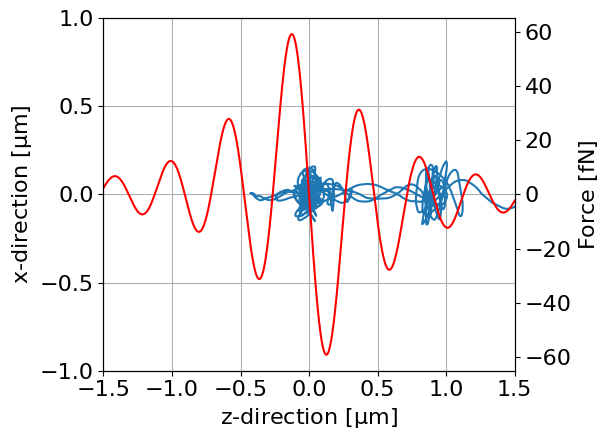

In [854]:
fig, ax1 = plt.subplots(figsize=(6.2,4.5))

ax1.plot(pos[:,1]*1e6, pos[:,0]*1e6)
ax1.set_xlabel(r"$\mathrm{z\text{-}direction\ [\mu m]}$",fontsize=16)
ax1.set_ylabel(r"$\mathrm{x\text{-}direction\ [\mu m]}$",fontsize=16)
ax1.set_ylim(-1,1)

ax2 = ax1.twinx()
ax2.plot(z*1e6, (F_grad_z_counter)*1e15, color='r')
ax2.set_ylabel("Force " + r"$\mathrm{ [fN]}$",fontsize=16)

ax1.grid(True)

#dados = [[pos[:,0]]]
#header = ['x']
#with open("dados_x.csv", mode="w", newline="") as arquivo_csv:
#    escritor = csv.writer(arquivo_csv)
#    escritor.writerow(header)  # Escreve o cabeçalho
#    escritor.writerows(dados)  # Escreve os dados

#plt.xlim(-1e-13,1e-13)
#plt.xlim(5.7965e-8,5.7967e-8)
plt.xlim(-1.5,1.5)

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

ax1.set_xticks([-1.5,-1, -0.5, 0, 0.5, 1,1.5])

plt.tight_layout()
#plt.savefig("trajectories_single.pdf", format='pdf', dpi=3000)
plt.show()